In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
fatal: destination path 'mmsegmentation' already exists and is not an empty directory.


In [3]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [4]:
%cd mmsegmentation

/content/mmsegmentation


In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [6]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-05-23 06:11:39--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  8.18MB/s    in 39s     

2022-05-23 06:12:19 (8.03 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [8]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'road','Boundary')
palette = [[0, 0, 0], [255, 255, 0], [255, 150, 0]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [9]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [10]:
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))

In [11]:
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (512, 512)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 1.5)),
    dict(type='RandomCrop', crop_size=(512, 512), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(512, 512), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

In [12]:
dataset_type = 'CityscapesDataset'
data_root = 'data/cityscapes/'

data = dict(
    samples_per_gpu=2,  #batch size
    workers_per_gpu=2,  
    train=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/train',
        ann_dir='gtFine/train',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations'),
            dict(
                type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 1.5)),
            dict(type='RandomCrop', crop_size=(512, 512), cat_max_ratio=0.75),
            dict(type='RandomFlip', prob=0.5),
            dict(type='PhotoMetricDistortion'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size=(512, 512), pad_val=0, seg_pad_val=255),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_semantic_seg'])
        ]),
    val=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1024, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]),
    test=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1024, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]))

In [13]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 3

cfg.model.decode_head.loss_decode = [dict(type='DiceLoss', loss_weight = 1.0, class_weight=[0.001, 0.7, 0.299]),
                                     dict(type='FocalLoss', loss_weight = 1.0, class_weight=[0.001, 0.7, 0.299]),
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none',class_weight=[0.001, 0.7, 0.299])]

In [14]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 1.5)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [15]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/road_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/road_dataset/contour_ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/road_dataset/mask_dir/train/up_train_road.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/road_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/road_dataset/contour_ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/road_dataset/mask_dir/train/up_val_road.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/road_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/road_dataset/contour_ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/road_dataset/mask_dir/val/up.txt'

In [16]:
'''
cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'images/up025'
cfg.data.train.ann_dir = 'labels'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/splits/road/train_road.txt'
'''

"\ncfg.data.train.type = 'SIADataset'\ncfg.data.train.data_root = '/content/drive/MyDrive/SIA'\ncfg.data.train.img_dir = 'images/up025'\ncfg.data.train.ann_dir = 'labels'\ncfg.data.train.pipeline = cfg.train_pipeline\ncfg.data.train.split = '/content/drive/MyDrive/SIA/splits/road/train_road.txt'\n"

In [17]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/DFL_class_weight073'

In [18]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(
                type='DiceLoss',
                loss_weight=1.0,
        

### 모델 학습

In [19]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-23 06:12:21,700 - mmseg - INFO - Loaded 542 images
2022-05-23 06:12:25,953 - mmseg - INFO - Loaded 66 images
2022-05-23 06:12:25,957 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-23 06:12:26,489 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([3]).
2022-05-23 06:12:26,496 - mmseg - INFO - Start running, host: root@52bcdad33ace, work_dir: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/DFL_class_weight073
2022-05-23 06:12:26,497 - mmseg - INFO - Hooks will be executed in the following order:
before_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 1.6 task/s, elapsed: 43s, ETA:     0s

2022-05-23 06:21:24,265 - mmseg - INFO - per class results:
2022-05-23 06:21:24,268 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  84.1 | 88.03 |
|    road    | 48.47 | 75.37 |
|  Boundary  | 29.91 | 50.82 |
+------------+-------+-------+
2022-05-23 06:21:24,270 - mmseg - INFO - Summary:
2022-05-23 06:21:24,272 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.91 | 54.16 | 71.41 |
+-------+-------+-------+
2022-05-23 06:21:24,275 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8191, mIoU: 0.5416, mAcc: 0.7141, IoU.background: 0.8410, IoU.road: 0.4847, IoU.Boundary: 0.2991, Acc.background: 0.8803, Acc.road: 0.7537, Acc.Boundary: 0.5082
2022-05-23 06:22:06,345 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 2:46:01, time: 0.847, data_time: 0.454, memory: 3323, decode.loss_dice: 0.1289, decode.loss_focal: 0.0116, decode.loss_lovasz: 0.1855, decode.acc_seg: 78.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.9 task/s, elapsed: 23s, ETA:     0s

2022-05-23 06:28:39,152 - mmseg - INFO - per class results:
2022-05-23 06:28:39,153 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 86.37 | 90.44 |
|    road    | 52.72 | 76.51 |
|  Boundary  | 33.03 | 52.86 |
+------------+-------+-------+
2022-05-23 06:28:39,155 - mmseg - INFO - Summary:
2022-05-23 06:28:39,157 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 84.15 | 57.37 | 73.27 |
+-------+-------+-------+
2022-05-23 06:28:39,161 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8415, mIoU: 0.5737, mAcc: 0.7327, IoU.background: 0.8637, IoU.road: 0.5272, IoU.Boundary: 0.3303, Acc.background: 0.9044, Acc.road: 0.7651, Acc.Boundary: 0.5286
2022-05-23 06:29:18,919 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 2:23:49, time: 0.627, data_time: 0.236, memory: 3324, decode.loss_dice: 0.1211, decode.loss_focal: 0.0105, decode.loss_lovasz: 0.1786, decode.acc_seg: 80.7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.9 task/s, elapsed: 23s, ETA:     0s

2022-05-23 06:35:50,277 - mmseg - INFO - per class results:
2022-05-23 06:35:50,279 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.58 | 94.52 |
|    road    | 52.88 | 66.46 |
|  Boundary  | 36.99 | 53.59 |
+------------+-------+-------+
2022-05-23 06:35:50,280 - mmseg - INFO - Summary:
2022-05-23 06:35:50,282 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.46 | 59.48 | 71.52 |
+-------+-------+-------+
2022-05-23 06:35:50,284 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8646, mIoU: 0.5948, mAcc: 0.7152, IoU.background: 0.8858, IoU.road: 0.5288, IoU.Boundary: 0.3699, Acc.background: 0.9452, Acc.road: 0.6646, Acc.Boundary: 0.5359
2022-05-23 06:36:30,038 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 2:11:09, time: 0.627, data_time: 0.236, memory: 3324, decode.loss_dice: 0.1127, decode.loss_focal: 0.0103, decode.loss_lovasz: 0.1711, decode.acc_seg: 82.3

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.9 task/s, elapsed: 23s, ETA:     0s

2022-05-23 06:43:01,680 - mmseg - INFO - per class results:
2022-05-23 06:43:01,682 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.97 | 93.98 |
|    road    | 55.16 | 69.11 |
|  Boundary  | 39.01 | 57.87 |
+------------+-------+-------+
2022-05-23 06:43:01,684 - mmseg - INFO - Summary:
2022-05-23 06:43:01,685 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.86 | 61.04 | 73.65 |
+-------+-------+-------+
2022-05-23 06:43:01,688 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8686, mIoU: 0.6104, mAcc: 0.7365, IoU.background: 0.8897, IoU.road: 0.5516, IoU.Boundary: 0.3901, Acc.background: 0.9398, Acc.road: 0.6911, Acc.Boundary: 0.5787
2022-05-23 06:43:41,384 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 2:01:10, time: 0.627, data_time: 0.236, memory: 3324, decode.loss_dice: 0.1028, decode.loss_focal: 0.0099, decode.loss_lovasz: 0.1643, decode.acc_seg: 84.0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.7 task/s, elapsed: 24s, ETA:     0s

2022-05-23 06:50:14,422 - mmseg - INFO - per class results:
2022-05-23 06:50:14,423 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.46 | 95.38 |
|    road    | 54.14 | 66.23 |
|  Boundary  | 39.44 | 55.57 |
+------------+-------+-------+
2022-05-23 06:50:14,424 - mmseg - INFO - Summary:
2022-05-23 06:50:14,429 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 87.37 | 61.02 | 72.4 |
+-------+-------+------+
2022-05-23 06:50:14,431 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8737, mIoU: 0.6102, mAcc: 0.7240, IoU.background: 0.8946, IoU.road: 0.5414, IoU.Boundary: 0.3944, Acc.background: 0.9538, Acc.road: 0.6623, Acc.Boundary: 0.5557
2022-05-23 06:50:54,219 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 1:52:21, time: 0.653, data_time: 0.262, memory: 3324, decode.loss_dice: 0.0955, decode.loss_focal: 0.0097, decode.loss_lovasz: 0.1589, decode.acc_seg: 84.7942, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.7 task/s, elapsed: 25s, ETA:     0s

2022-05-23 06:57:28,462 - mmseg - INFO - per class results:
2022-05-23 06:57:28,464 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.06 | 93.84 |
|    road    |  55.9 | 69.67 |
|  Boundary  | 39.65 | 59.24 |
+------------+-------+-------+
2022-05-23 06:57:28,465 - mmseg - INFO - Summary:
2022-05-23 06:57:28,467 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.98 | 61.54 | 74.25 |
+-------+-------+-------+
2022-05-23 06:57:28,469 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8698, mIoU: 0.6154, mAcc: 0.7425, IoU.background: 0.8906, IoU.road: 0.5590, IoU.Boundary: 0.3965, Acc.background: 0.9384, Acc.road: 0.6967, Acc.Boundary: 0.5924
2022-05-23 06:58:08,546 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 1:44:08, time: 0.647, data_time: 0.253, memory: 3324, decode.loss_dice: 0.1032, decode.loss_focal: 0.0097, decode.loss_lovasz: 0.1660, decode.acc_seg: 83.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.9 task/s, elapsed: 23s, ETA:     0s

2022-05-23 07:04:38,215 - mmseg - INFO - per class results:
2022-05-23 07:04:38,217 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.91 | 93.75 |
|    road    | 55.51 | 70.68 |
|  Boundary  | 39.08 | 57.91 |
+------------+-------+-------+
2022-05-23 07:04:38,219 - mmseg - INFO - Summary:
2022-05-23 07:04:38,220 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.84 | 61.17 | 74.11 |
+-------+-------+-------+
2022-05-23 07:04:38,222 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8684, mIoU: 0.6117, mAcc: 0.7411, IoU.background: 0.8891, IoU.road: 0.5551, IoU.Boundary: 0.3908, Acc.background: 0.9375, Acc.road: 0.7068, Acc.Boundary: 0.5791
2022-05-23 07:05:20,083 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 1:36:05, time: 0.648, data_time: 0.257, memory: 3324, decode.loss_dice: 0.0933, decode.loss_focal: 0.0098, decode.loss_lovasz: 0.1565, decode.acc_seg: 85.0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.7 task/s, elapsed: 24s, ETA:     0s

2022-05-23 07:11:49,805 - mmseg - INFO - per class results:
2022-05-23 07:11:49,807 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.08 | 93.93 |
|    road    | 55.62 | 69.48 |
|  Boundary  | 39.83 | 59.13 |
+------------+-------+-------+
2022-05-23 07:11:49,808 - mmseg - INFO - Summary:
2022-05-23 07:11:49,811 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.02 | 61.51 | 74.18 |
+-------+-------+-------+
2022-05-23 07:11:49,813 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8702, mIoU: 0.6151, mAcc: 0.7418, IoU.background: 0.8908, IoU.road: 0.5562, IoU.Boundary: 0.3983, Acc.background: 0.9393, Acc.road: 0.6948, Acc.Boundary: 0.5913
2022-05-23 07:12:29,818 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 1:28:13, time: 0.643, data_time: 0.250, memory: 3324, decode.loss_dice: 0.0873, decode.loss_focal: 0.0094, decode.loss_lovasz: 0.1499, decode.acc_seg: 86.9

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.7 task/s, elapsed: 24s, ETA:     0s

2022-05-23 07:19:00,640 - mmseg - INFO - per class results:
2022-05-23 07:19:00,642 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.46 | 94.87 |
|    road    | 54.93 | 66.17 |
|  Boundary  | 40.94 |  59.3 |
+------------+-------+-------+
2022-05-23 07:19:00,643 - mmseg - INFO - Summary:
2022-05-23 07:19:00,646 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.46 | 61.78 | 73.45 |
+-------+-------+-------+
2022-05-23 07:19:00,648 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8746, mIoU: 0.6178, mAcc: 0.7345, IoU.background: 0.8946, IoU.road: 0.5493, IoU.Boundary: 0.4094, Acc.background: 0.9487, Acc.road: 0.6617, Acc.Boundary: 0.5930
2022-05-23 07:19:40,179 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 1:20:31, time: 0.636, data_time: 0.247, memory: 3324, decode.loss_dice: 0.0924, decode.loss_focal: 0.0092, decode.loss_lovasz: 0.1553, decode.acc_seg: 85.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.7 task/s, elapsed: 25s, ETA:     0s

2022-05-23 07:26:11,363 - mmseg - INFO - per class results:
2022-05-23 07:26:11,365 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.67 | 94.96 |
|    road    | 54.31 | 66.16 |
|  Boundary  | 41.09 | 59.26 |
+------------+-------+-------+
2022-05-23 07:26:11,366 - mmseg - INFO - Summary:
2022-05-23 07:26:11,368 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.52 | 61.69 | 73.46 |
+-------+-------+-------+
2022-05-23 07:26:11,369 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8752, mIoU: 0.6169, mAcc: 0.7346, IoU.background: 0.8967, IoU.road: 0.5431, IoU.Boundary: 0.4109, Acc.background: 0.9496, Acc.road: 0.6616, Acc.Boundary: 0.5926
2022-05-23 07:26:51,254 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 1:12:56, time: 0.648, data_time: 0.256, memory: 3324, decode.loss_dice: 0.0905, decode.loss_focal: 0.0090, decode.loss_lovasz: 0.1461, decode.acc_seg: 86.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.7 task/s, elapsed: 24s, ETA:     0s

2022-05-23 07:33:21,718 - mmseg - INFO - per class results:
2022-05-23 07:33:21,720 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.54 | 94.25 |
|    road    | 56.77 | 71.12 |
|  Boundary  | 40.77 | 59.49 |
+------------+-------+-------+
2022-05-23 07:33:21,721 - mmseg - INFO - Summary:
2022-05-23 07:33:21,724 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.47 | 62.36 | 74.95 |
+-------+-------+-------+
2022-05-23 07:33:21,728 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8747, mIoU: 0.6236, mAcc: 0.7495, IoU.background: 0.8954, IoU.road: 0.5677, IoU.Boundary: 0.4077, Acc.background: 0.9425, Acc.road: 0.7112, Acc.Boundary: 0.5949
2022-05-23 07:34:01,403 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 1:05:24, time: 0.642, data_time: 0.252, memory: 3324, decode.loss_dice: 0.0872, decode.loss_focal: 0.0082, decode.loss_lovasz: 0.1511, decode.acc_seg: 87.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.7 task/s, elapsed: 25s, ETA:     0s

2022-05-23 07:40:31,352 - mmseg - INFO - per class results:
2022-05-23 07:40:31,354 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.08 | 93.22 |
|    road    | 56.05 |  74.9 |
|  Boundary  | 40.16 | 59.14 |
+------------+-------+-------+
2022-05-23 07:40:31,355 - mmseg - INFO - Summary:
2022-05-23 07:40:31,357 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.98 | 61.76 | 75.75 |
+-------+-------+-------+
2022-05-23 07:40:31,359 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8698, mIoU: 0.6176, mAcc: 0.7575, IoU.background: 0.8908, IoU.road: 0.5605, IoU.Boundary: 0.4016, Acc.background: 0.9322, Acc.road: 0.7490, Acc.Boundary: 0.5914
2022-05-23 07:41:11,316 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 0:57:56, time: 0.648, data_time: 0.255, memory: 3324, decode.loss_dice: 0.0809, decode.loss_focal: 0.0087, decode.loss_lovasz: 0.1447, decode.acc_seg: 87.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.9 task/s, elapsed: 23s, ETA:     0s

2022-05-23 07:47:39,249 - mmseg - INFO - per class results:
2022-05-23 07:47:39,251 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.39 | 93.61 |
|    road    | 56.25 | 73.78 |
|  Boundary  | 40.45 | 59.37 |
+------------+-------+-------+
2022-05-23 07:47:39,253 - mmseg - INFO - Summary:
2022-05-23 07:47:39,258 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.21 | 62.03 | 75.59 |
+-------+-------+-------+
2022-05-23 07:47:39,259 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8721, mIoU: 0.6203, mAcc: 0.7559, IoU.background: 0.8939, IoU.road: 0.5625, IoU.Boundary: 0.4045, Acc.background: 0.9361, Acc.road: 0.7378, Acc.Boundary: 0.5937
2022-05-23 07:48:21,093 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 0:50:30, time: 0.648, data_time: 0.257, memory: 3324, decode.loss_dice: 0.0837, decode.loss_focal: 0.0085, decode.loss_lovasz: 0.1456, decode.acc_seg: 87.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.9 task/s, elapsed: 23s, ETA:     0s

2022-05-23 07:54:49,507 - mmseg - INFO - per class results:
2022-05-23 07:54:49,509 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.88 | 94.75 |
|    road    | 56.66 | 72.65 |
|  Boundary  | 40.97 | 57.65 |
+------------+-------+-------+
2022-05-23 07:54:49,510 - mmseg - INFO - Summary:
2022-05-23 07:54:49,511 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 87.76 | 62.5 | 75.02 |
+-------+------+-------+
2022-05-23 07:54:49,516 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8776, mIoU: 0.6250, mAcc: 0.7502, IoU.background: 0.8988, IoU.road: 0.5666, IoU.Boundary: 0.4097, Acc.background: 0.9475, Acc.road: 0.7265, Acc.Boundary: 0.5765
2022-05-23 07:55:31,384 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 0:43:07, time: 0.649, data_time: 0.258, memory: 3324, decode.loss_dice: 0.0810, decode.loss_focal: 0.0085, decode.loss_lovasz: 0.1437, decode.acc_seg: 88.5311,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.9 task/s, elapsed: 23s, ETA:     0s

2022-05-23 08:01:59,642 - mmseg - INFO - per class results:
2022-05-23 08:01:59,644 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.83 | 94.65 |
|    road    |  56.4 | 73.62 |
|  Boundary  |  40.4 | 56.67 |
+------------+-------+-------+
2022-05-23 08:01:59,646 - mmseg - INFO - Summary:
2022-05-23 08:01:59,648 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.64 | 62.21 | 74.98 |
+-------+-------+-------+
2022-05-23 08:01:59,653 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8764, mIoU: 0.6221, mAcc: 0.7498, IoU.background: 0.8983, IoU.road: 0.5640, IoU.Boundary: 0.4040, Acc.background: 0.9465, Acc.road: 0.7362, Acc.Boundary: 0.5667
2022-05-23 08:02:39,405 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 0:35:45, time: 0.628, data_time: 0.237, memory: 3324, decode.loss_dice: 0.0801, decode.loss_focal: 0.0088, decode.loss_lovasz: 0.1434, decode.acc_seg: 87.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.7 task/s, elapsed: 24s, ETA:     0s

2022-05-23 08:09:10,999 - mmseg - INFO - per class results:
2022-05-23 08:09:11,001 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.63 | 94.54 |
|    road    | 55.99 | 69.38 |
|  Boundary  | 41.18 | 59.68 |
+------------+-------+-------+
2022-05-23 08:09:11,002 - mmseg - INFO - Summary:
2022-05-23 08:09:11,004 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.56 | 62.27 | 74.54 |
+-------+-------+-------+
2022-05-23 08:09:11,006 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8756, mIoU: 0.6227, mAcc: 0.7454, IoU.background: 0.8963, IoU.road: 0.5599, IoU.Boundary: 0.4118, Acc.background: 0.9454, Acc.road: 0.6938, Acc.Boundary: 0.5968
2022-05-23 08:09:50,621 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 0:28:26, time: 0.641, data_time: 0.252, memory: 3324, decode.loss_dice: 0.0787, decode.loss_focal: 0.0079, decode.loss_lovasz: 0.1403, decode.acc_seg: 88.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.7 task/s, elapsed: 25s, ETA:     0s

2022-05-23 08:16:22,024 - mmseg - INFO - per class results:
2022-05-23 08:16:22,026 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.73 | 94.52 |
|    road    |  56.4 | 72.63 |
|  Boundary  | 40.66 | 57.75 |
+------------+-------+-------+
2022-05-23 08:16:22,027 - mmseg - INFO - Summary:
2022-05-23 08:16:22,029 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.59 | 62.26 | 74.97 |
+-------+-------+-------+
2022-05-23 08:16:22,031 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8759, mIoU: 0.6226, mAcc: 0.7497, IoU.background: 0.8973, IoU.road: 0.5640, IoU.Boundary: 0.4066, Acc.background: 0.9452, Acc.road: 0.7263, Acc.Boundary: 0.5775
2022-05-23 08:17:01,595 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:21:07, time: 0.642, data_time: 0.253, memory: 3324, decode.loss_dice: 0.0801, decode.loss_focal: 0.0080, decode.loss_lovasz: 0.1365, decode.acc_seg: 88.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.6 task/s, elapsed: 25s, ETA:     0s

2022-05-23 08:23:35,066 - mmseg - INFO - per class results:
2022-05-23 08:23:35,068 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.01 | 95.25 |
|    road    | 56.09 | 72.38 |
|  Boundary  |  40.2 | 55.27 |
+------------+-------+-------+
2022-05-23 08:23:35,070 - mmseg - INFO - Summary:
2022-05-23 08:23:35,072 - mmseg - INFO - 
+------+------+------+
| aAcc | mIoU | mAcc |
+------+------+------+
| 87.8 | 62.1 | 74.3 |
+------+------+------+
2022-05-23 08:23:35,074 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8780, mIoU: 0.6210, mAcc: 0.7430, IoU.background: 0.9001, IoU.road: 0.5609, IoU.Boundary: 0.4020, Acc.background: 0.9525, Acc.road: 0.7238, Acc.Boundary: 0.5527
2022-05-23 08:24:14,751 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:13:50, time: 0.651, data_time: 0.261, memory: 3324, decode.loss_dice: 0.0766, decode.loss_focal: 0.0083, decode.loss_lovasz: 0.1365, decode.acc_seg: 88.5940, loss: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.6 task/s, elapsed: 25s, ETA:     0s

2022-05-23 08:30:47,296 - mmseg - INFO - per class results:
2022-05-23 08:30:47,298 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.62 | 94.14 |
|    road    | 56.25 | 74.31 |
|  Boundary  | 40.43 | 57.65 |
+------------+-------+-------+
2022-05-23 08:30:47,300 - mmseg - INFO - Summary:
2022-05-23 08:30:47,302 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 87.44 | 62.1 | 75.37 |
+-------+------+-------+
2022-05-23 08:30:47,305 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8744, mIoU: 0.6210, mAcc: 0.7537, IoU.background: 0.8962, IoU.road: 0.5625, IoU.Boundary: 0.4043, Acc.background: 0.9414, Acc.road: 0.7431, Acc.Boundary: 0.5765
2022-05-23 08:31:27,140 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:06:33, time: 0.649, data_time: 0.258, memory: 3324, decode.loss_dice: 0.0852, decode.loss_focal: 0.0085, decode.loss_lovasz: 0.1466, decode.acc_seg: 87.7075,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.6 task/s, elapsed: 25s, ETA:     0s

2022-05-23 08:38:00,320 - mmseg - INFO - per class results:
2022-05-23 08:38:00,322 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.68 | 94.28 |
|    road    | 56.41 | 71.77 |
|  Boundary  | 41.35 | 59.74 |
+------------+-------+-------+
2022-05-23 08:38:00,324 - mmseg - INFO - Summary:
2022-05-23 08:38:00,325 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.59 | 62.48 | 75.26 |
+-------+-------+-------+
2022-05-23 08:38:00,328 - mmseg - INFO - Iter(val) [66]	aAcc: 0.8759, mIoU: 0.6248, mAcc: 0.7526, IoU.background: 0.8968, IoU.road: 0.5641, IoU.Boundary: 0.4135, Acc.background: 0.9428, Acc.road: 0.7177, Acc.Boundary: 0.5974


### 모델 결과 시각화

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/DFL_class_weight073/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


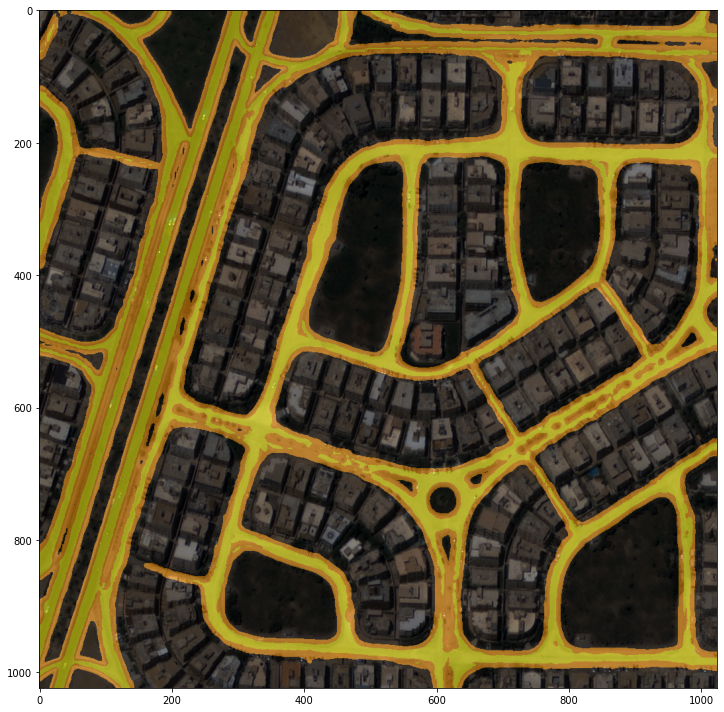

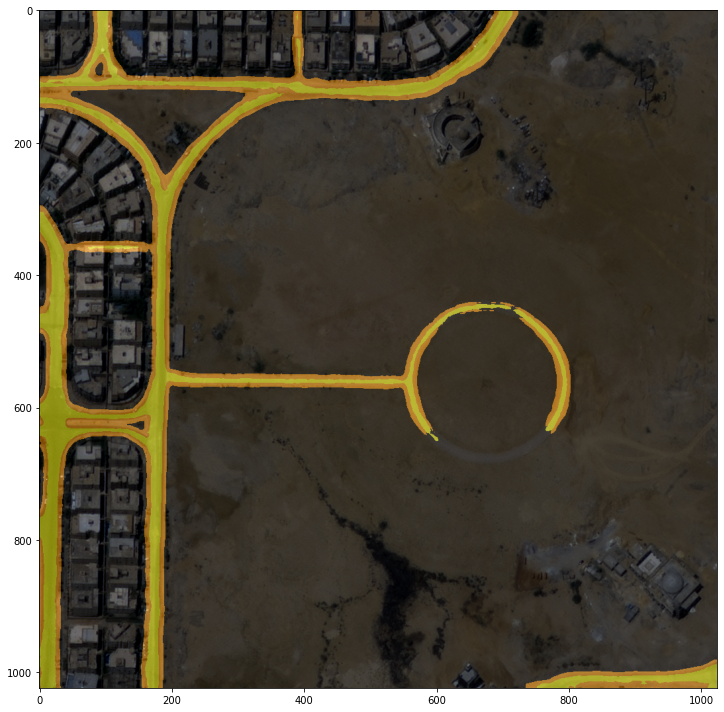

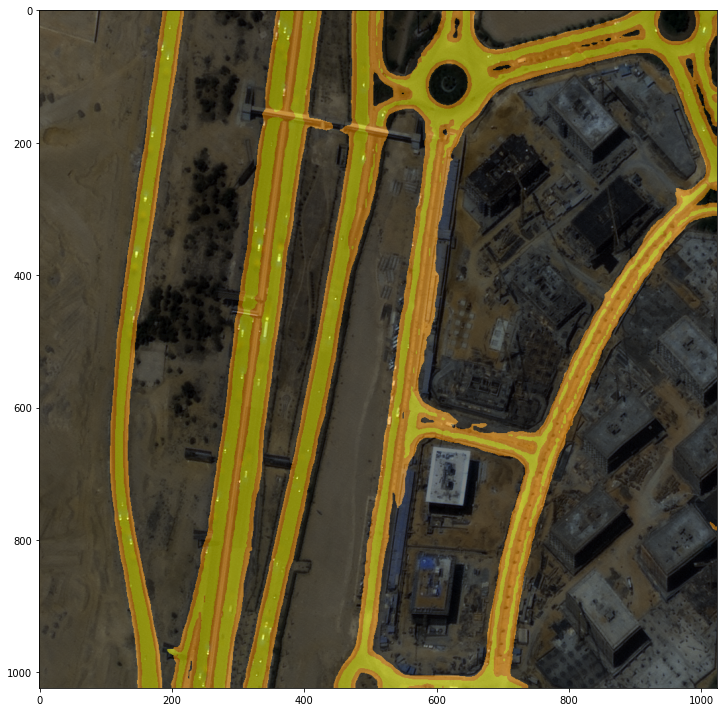

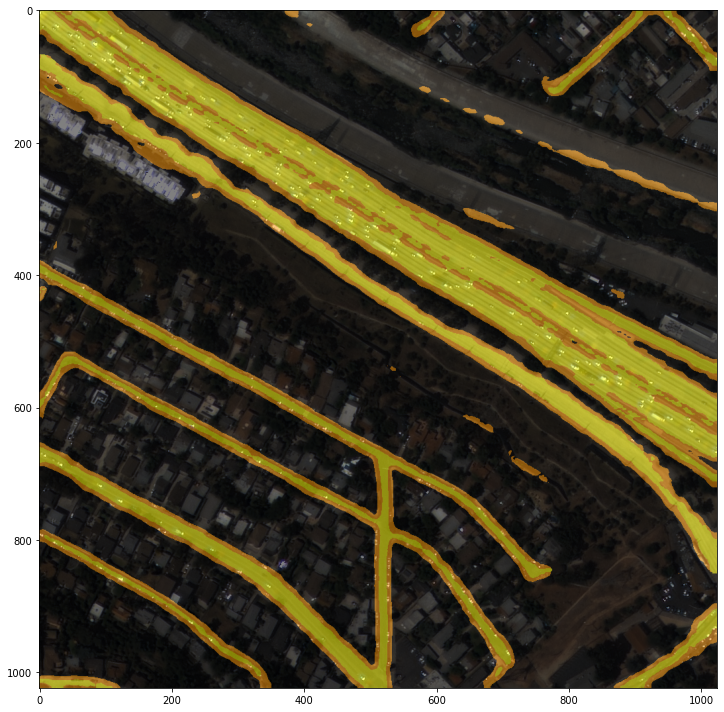

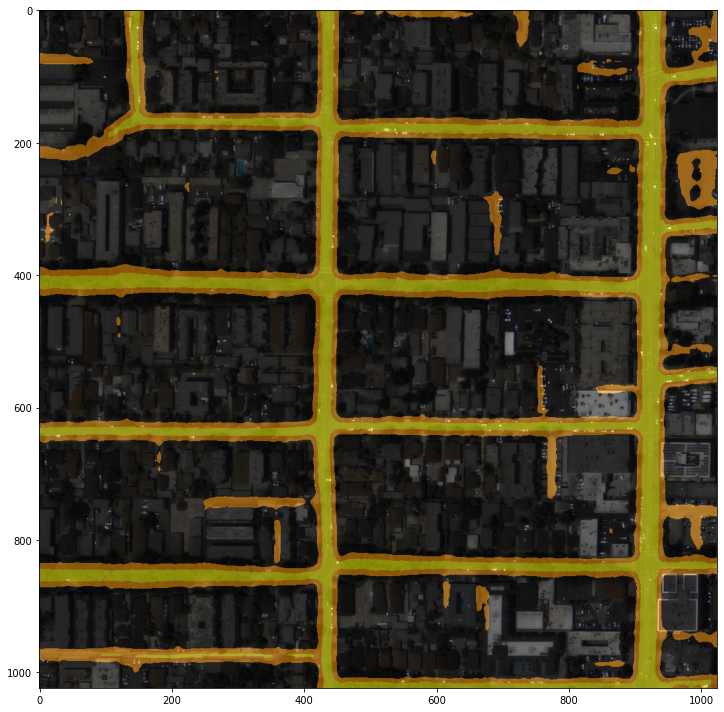

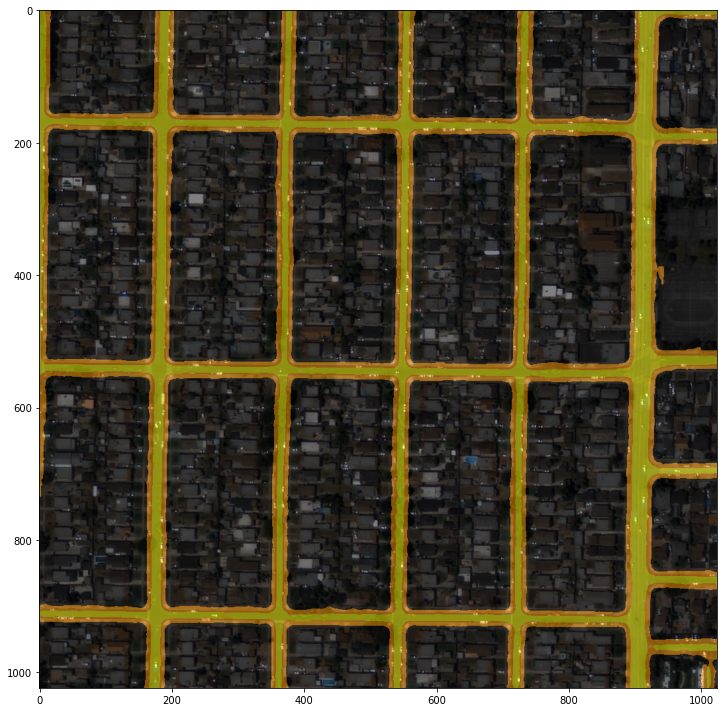

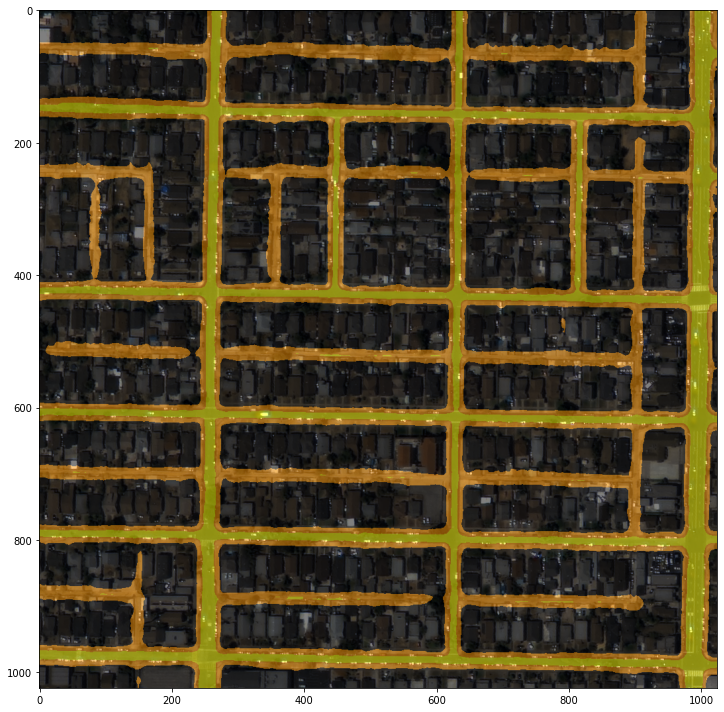

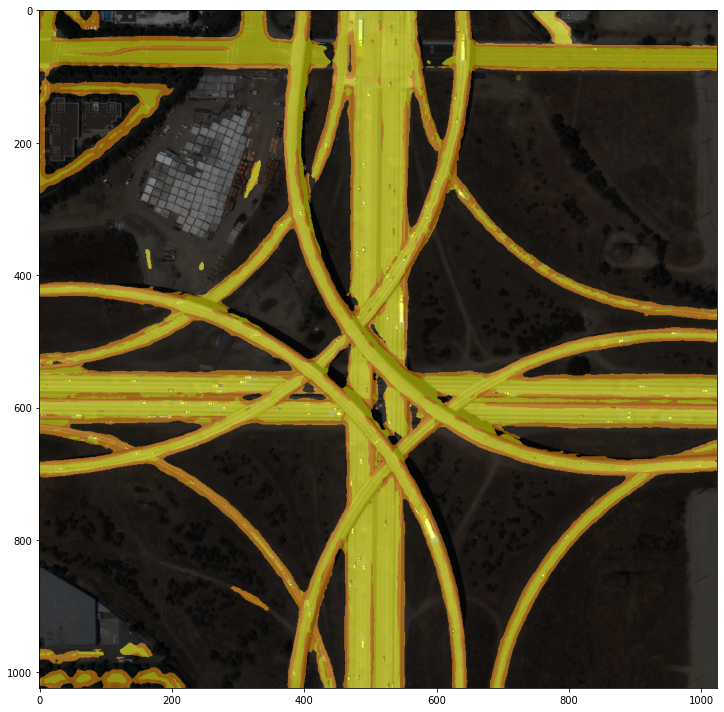

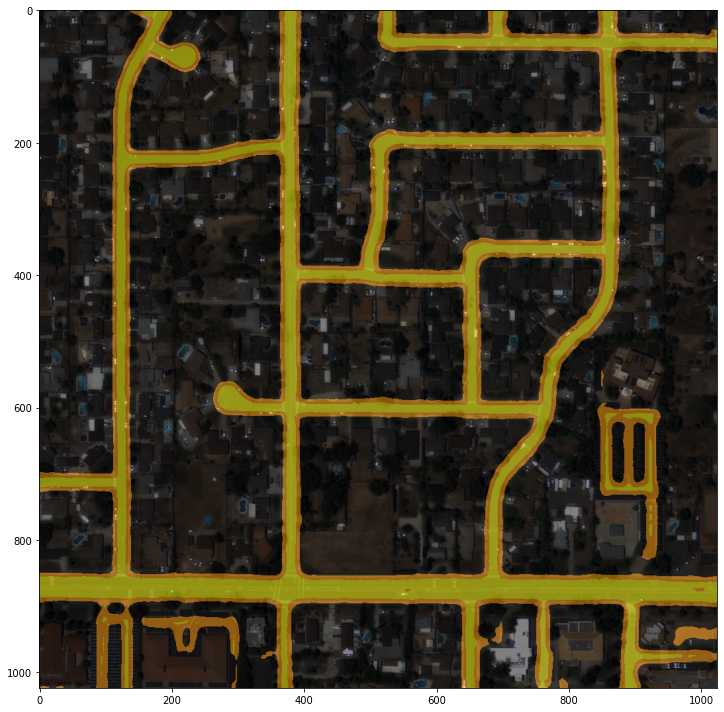

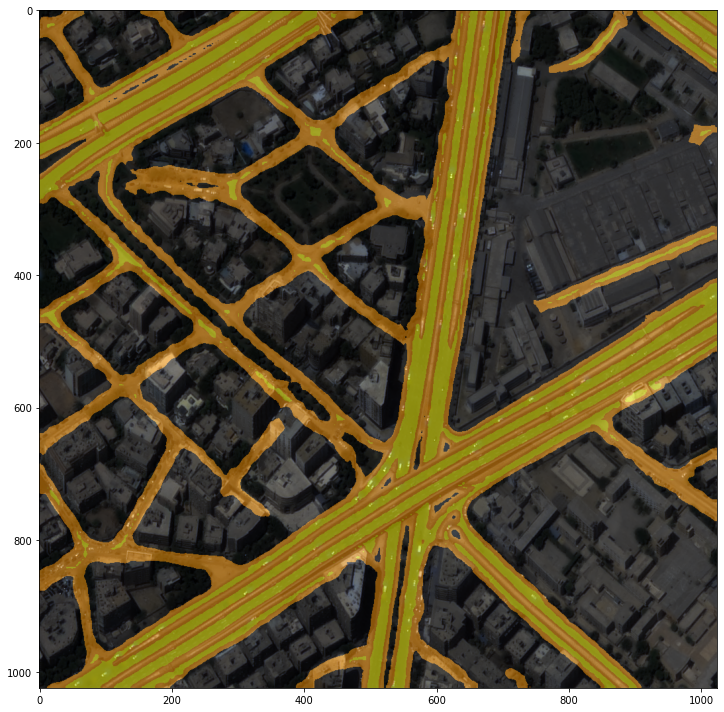

In [20]:
img_result = ['BLD00002_PS3_K3A_NIA0276.png',
              'BLD00010_PS3_K3A_NIA0276.png',
              'BLD00047_PS3_K3A_NIA0276.png',
              'BLD12071_PS3_K3A_NIA0391.png',
              'BLD11907_PS3_K3A_NIA0391.png',
              'BLD11611_PS3_K3A_NIA0390.png',
              'BLD11474_PS3_K3A_NIA0390.png',
              'BLD10413_PS3_K3A_NIA0388.png',
              'BLD10150_PS3_K3A_NIA0388.png',
              'BLD00836_PS3_K3A_NIA0277.png']

checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/DFL_class_weight073/iter_20000.pth'  #학습된 모델


# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

for ir in range(len(img_result)):
  img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/'+img_result[ir])
  result = inference_segmentor(model_ckpt, img)
  show_result_pyplot(model_ckpt, img, result, palette)
